# Homework 2 
### Ziying Wang

## Question 1 -- Cartpole-v0

In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
#import tflearn
#from tflearn.layers.core import input_data, dropout, fully_connected
#from tflearn.layers.estimator import regression
#from statistics import mean, median
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
env = gym.make('CartPole-v0')
env.reset()
LR = 0.05
gamma = 0.95
H = 10 #hidden layer neurons
n_epochs = 5000
state_size = 4 # input dimensionality
C = 2 # class number
n_actions = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/ziyingwang/anaconda3/envs/dl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [7]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    for i in reversed(range(len(r))):
        running_add = running_add * gamma + r[i]
        discounted_r[i] = running_add
    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r)
    return discounted_r

In [8]:
tf.reset_default_graph()

with tf.name_scope("input"):
    input_state_ = tf.placeholder(tf.float32, shape = (None, state_size), name="input_state")
    action_ = tf.placeholder(tf.int32, shape = None, name="action")
    reward_ = tf.placeholder(tf.float32,shape = None, name="reward")

with tf.name_scope("layers"):
    hidden1 = tf.layers.dense(input_state_, H, name = "hidden1", activation = tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer())
    hidden2 = tf.layers.dense(hidden1, H, name = "hidden2", activation = tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer()) 

    logits = tf.layers.dense(hidden2, n_actions)
    y_prob = tf.nn.softmax(logits)

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action_, logits=logits)
    loss_op = tf.reduce_mean(xentropy*reward_)
#     loss_op = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits_v2(labels=action_, logits=logits))*reward_) 

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LR)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())




In [9]:
all_rewards = []
running_means = []
saver = tf.train.Saver()
# init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     if os.path.isfile(checkpoint_path + ".index"):
#         saver.restore(sess, checkpoint_path)
#     else:
#         sess.run(init)

    for epoch in range(n_epochs):
        
        rewards = []
        observations = []
        actions = []
        
        state = env.reset()
        
        while True:
            action_prob = sess.run(y_prob,
                                   feed_dict = {input_state_: state.reshape([1,state_size])})
        
            action = np.random.choice(range(n_actions), p=action_prob.ravel())
            obs, reward, done, info = env.step(action)
            rewards.append(reward)
            observations.append(state)
            actions.append(action)
            
            if done:
                discounted_reward = discount_rewards(rewards)
                _,_ = sess.run([loss_op, train_op],
                               feed_dict = {input_state_: np.vstack(np.array(observations)),
                                           action_:actions,
                                           reward_: discounted_reward}) 
                break
            state = obs
            
        all_rewards.append(sum(rewards))
        tail = all_rewards[epoch-100:epoch]
        running_means.append(np.mean(tail))
        
        if np.mean(tail) >= 195:
            saver.save(sess, "./model.ckpt")
            print("Final epoch:", epoch,", Reward:", np.mean(all_rewards[epoch-100:epoch]), "Max Reward:", max(all_rewards))
            break
        if epoch%500 == 0:
            print("epoch:", epoch,", Reward:", np.mean(all_rewards[epoch-100:epoch]), "Max Reward:", max(all_rewards))

epoch: 0 , Reward: nan Max Reward: 21.0
epoch: 500 , Reward: 57.36 Max Reward: 189.0
epoch: 1000 , Reward: 167.65 Max Reward: 200.0
Final epoch: 1402 , Reward: 195.26 Max Reward: 200.0


In [10]:
import pickle
with open("all_rewards.txt", "wb") as fp:   
    pickle.dump(all_rewards, fp)

with open("running_mean.txt", "wb") as fp:   
    pickle.dump(running_means, fp)




In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

with open("all_rewards.txt", "rb") as fp:   # Unpickling
    all_rewards = pickle.load(fp)
    
with open("running_mean.txt", "rb") as fp:   # Unpickling
    running_mean = pickle.load(fp)
    
# plt.plot(all_rewards)

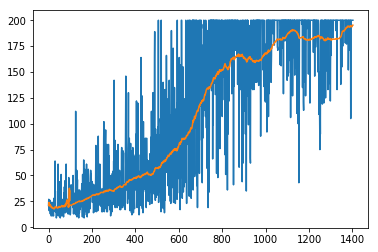

In [2]:
plt.plot(range(len(all_rewards)), all_rewards, range(len(all_rewards)), running_mean)
